In [27]:
import pandas as pd
import numpy as np
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde

import os
import shutil

In [31]:
# Define the name for the main folder
name_run = 'facies_model_sis/'

# Create the working folders if they do not exists
os.makedirs('./'+ name_run +'/data/', exist_ok=True)
os.makedirs('./'+ name_run +'/outputs/', exist_ok=True)
os.makedirs('./'+ name_run +'/figures/', exist_ok=True)
os.makedirs('./'+ name_run +'/outputs/acc/', exist_ok=True)

In [32]:
# Set the working folders

datdir = './'+ name_run +'/data/'
outdir = './'+ name_run +'/outputs/'
figdir = './'+ name_run +'/figures/'
img = './image_conv/'
exedir = './exes/'

In [7]:
# Define grid

griddef = gs.GridDef(griddef = [130, 0, 25.0, 130, 0, 25.0,
                     1, 0.5, 1.0])
griddef

Pygeostat GridDef:
130 0.0 25.0 
130 0.0 25.0 
1 0.5 1.0

In [8]:
# Function to select the realization

def get_realization(df: pd.DataFrame, realization_number: int) -> np.ndarray:

    grid_shape=(griddef.nx, griddef.ny)
    realization_size = np.prod(grid_shape)
    
    # Calculate the start and end indices for the desired realization
    start_idx = realization_number * realization_size
    end_idx = start_idx + realization_size
    
    # Check if the realization_number is within the valid range
    if realization_number < 0 or realization_number >= nreal:
        raise ValueError("Realization number is out of range.")

    # Retrieve the realization as a 1D array
    realization_1d = df.iloc[start_idx:end_idx, 0].values

    return realization_1d

# Input data

In [9]:
# Import the input files

input_data = gs.DataFile(datdir + 'Reference_image.dat')
sec_data = gs.DataFile(datdir + 'Acoustic_impedance.out')
sampled_data = gs.DataFile(datdir + 'data_points.dat')


In [10]:
# Define the categories (facies) and their corresponding colors
facies = [1, 2, 3]
colors = ['#FFA500', '#FFFF00', '#808080']

# Assign the facies labels dictionary to the DataFile object
input_data.catdict = {1: "Coarse sand", 2: "Sand", 3: "Shale"}
colordict = {c: colors[i] for i, c in enumerate(facies)}

cmap_fac = mcolors.ListedColormap(colors)

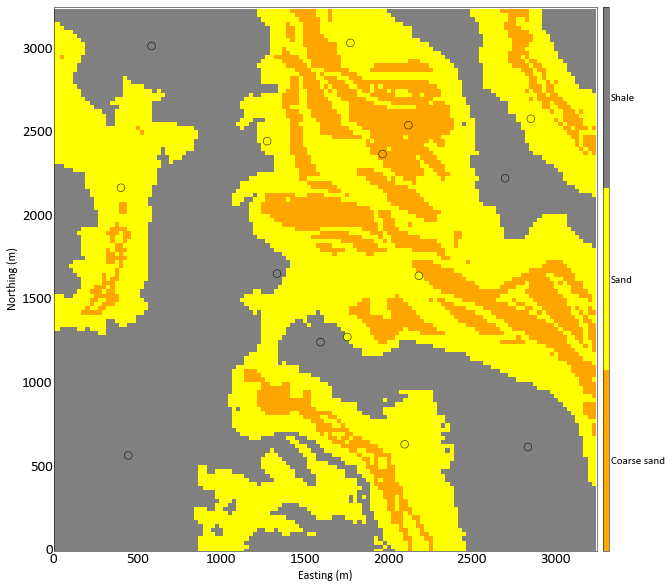

In [11]:
fig, ax = plt.subplots(figsize=(10,10),)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

gs.location_plot(sampled_data, var = 'RT', s = 60, title='Samples', ax=ax, edgecolor = 'black',
                         linewidth=0.5, cmap=cmap_fac, xlim=(0,3250), ylim=(0,3250))

gs.slice_plot(input_data, var = 'Facies', catdata= True, catdict=input_data.catdict
              , griddef = griddef, orient = 'xy', ax=ax, title = '', clim=(1,3), cmap=cmap_fac)



gs.export_image(figdir + 'input_data.png', dpi = 300)


The reference image is a synthetic example inspired by a braided fluvial system. It is not used in the simulation but serves for quality control of the model and is the source of the sampled data.

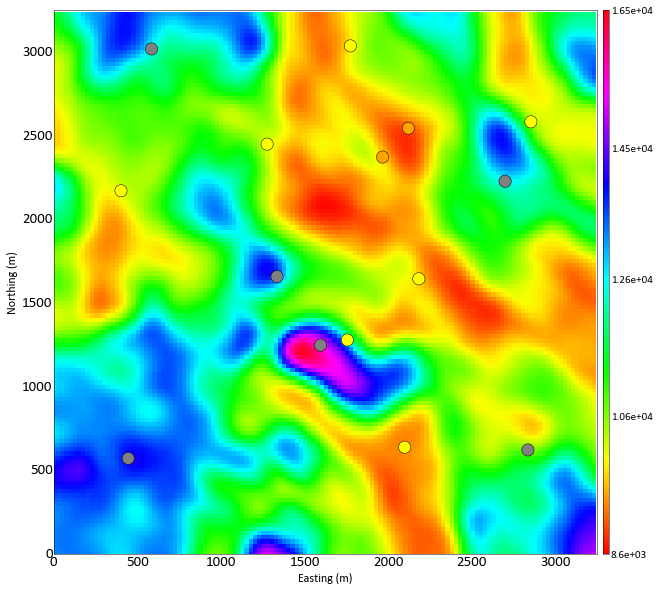

In [12]:
fig, ax = plt.subplots(figsize=(10,10),)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


gs.location_plot(sampled_data, var = 'RT', s = 150, title='Samples', ax=ax, edgecolor = 'black',
                         linewidth=0.5, cmap=cmap_fac, xlim=(0,3250), ylim=(0,3250))

gs.slice_plot(sec_data, var = 'AI', griddef = griddef, orient = 'xy', ax=ax, title = '', clim=(1,3), cmap='hsv')

gs.export_image(figdir + 'sec.png', dpi = 300)

The secondary variable was constructed from the reference image using a non-conditional simulation with specific distributions for each facies. It represents a potential response of the acoustic impedance attribute.

# Facies proportions 

## Collocated samples

In [12]:
# Identify the 1D index in the impedance using the coordinates in sample data

idx, _ = griddef.get_index(sampled_data['X'], sampled_data['Y'], sampled_data['Z'])

sampled_data['AI'] = sec_data['AI'].iloc[idx].values

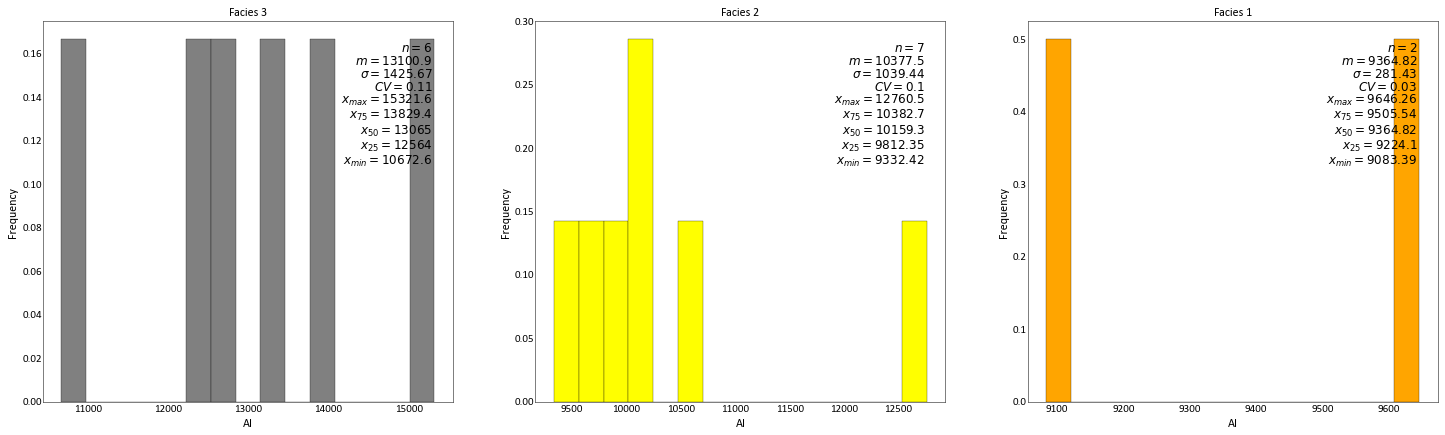

In [13]:
fig, axs = plt.subplots(1,3, figsize=(25,7))

for i, c in zip(range(3),colors):
    gs.histogram_plot(sampled_data.data.loc[sampled_data['RT'] == (i+1),'AI'], bins=15, ax=axs[2-i],
                      color = c, title='Facies {}'.format(i+1))
    
gs.export_image(figdir + 'facies_per_AI.png', dpi = 300)

In [14]:
# Initial facies proportion

fac_prop = []

for i in range(3):
    temp = sampled_data['Ind{}'.format(i+1)].mean()
    fac_prop.append(temp)

## Facies conditional distributions 

In [42]:
# Calculate the distributions using KDE for each of the facies.

kdes_sci = []

for i in range(3):    
    x_data = sampled_data[sampled_data['RT'] == (i+1)]['AI']
    kdev2 = gaussian_kde(x_data, bw_method= 'silverman')
    kdes_sci.append(kdev2)

# Change the smothing factor from the distributions    

mult_factor2 = 1

print('New Bandwidth')

for i in range(3):
    kdes_sci[i].set_bandwidth(bw_method = kdes_sci[i].factor * mult_factor2)  
    print('Bandwidth:', kdes_sci[i].factor) 
    

New Bandwidth
Bandwidth: 0.9221079114817278
Bandwidth: 0.7177416344286515
Bandwidth: 0.7402143449743067


In [43]:
# Define min and max from secondary data

imp_min = min(sec_data['AI'])
imp_max = max(sec_data['AI'])

In [44]:
# Define X axis and plot the density

density_plot = []
plot_x_data = np.linspace(imp_min, imp_max, 50)

for i in range(3):
    temp = kdes_sci[i](plot_x_data)
    density_plot.append(temp)

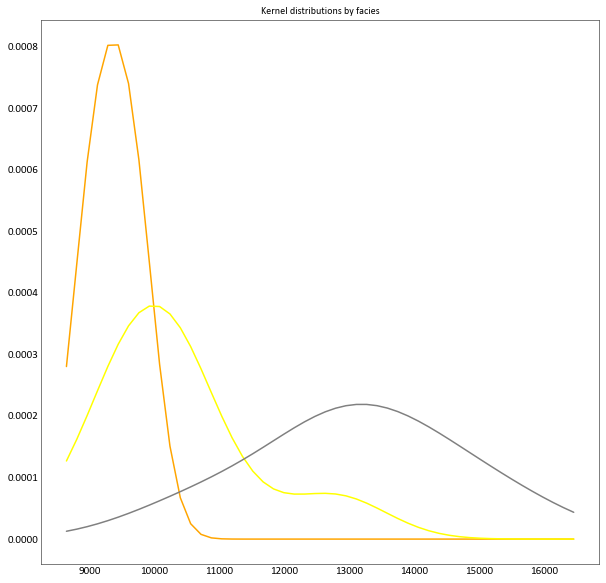

In [45]:
fig, ax = plt.subplots(figsize=(10,10),)

plt.title("Kernel distributions by facies")

for i, c in zip(range(3),colors):
    plt.plot(plot_x_data , density_plot[i], color = c)
    
gs.export_image(figdir + 'distributions_{}.png'.format(mult_factor2), dpi = 300)

### Calculate $P(A(\mathbf{u})|y(\mathbf{u}))$

In [46]:
for i in range(3):
    sec_data['f_Y1_A{}'.format(i+1)] = kdes_sci[i](sec_data['AI'])

#### Proportions correction  

In [47]:
# Model the KDE marginal from secondary data
kde_mar_sec = gaussian_kde(sec_data['AI'], bw_method= 'silverman')

# Change the bandwidth to mult_factor2 * silverman value
kde_mar_sec.set_bandwidth(bw_method = kde_mar_sec.factor * mult_factor2)

In [48]:
# Apply the KDE secondary marginal in the map 

sec_data['f_Y1'] = kde_mar_sec(sec_data['AI'])

# Sum the likelihoods from each facies 

sec_data['f_Y1_sum'] = sec_data['f_Y1_A1'] * fac_prop [0] + sec_data['f_Y1_A2'] * fac_prop [1] + sec_data['f_Y1_A3'] * fac_prop [2]


In [49]:
sec_data['rt_corr'] = sec_data['f_Y1'] / sec_data['f_Y1_sum']

In [50]:
# Correct the marginal

for i in range(3):
    sec_data['f_Y1_A{}_corr'.format(i+1)] = sec_data['f_Y1_A{}'.format(i+1)] * sec_data['rt_corr']

\begin{equation}
 P(A(\mathbf{u})|y(\mathbf{u})) = P(A) \cdot \frac{1}{f_{Y}(y(\mathbf{u}))}* f_{Y|A}(y(\mathbf{u}))
\end{equation}

In [51]:
for i in range(3):
    sec_data['pab_f{}'.format(i+1)] = fac_prop[i] * (1/sec_data['f_Y1']) * sec_data['f_Y1_A{}_corr'.format(i+1)]

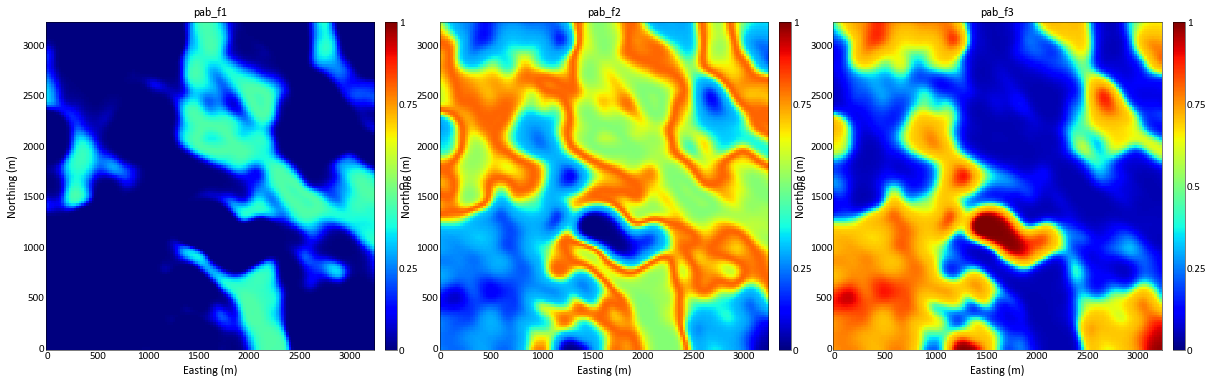

In [52]:
fig, axs = plt.subplots(1,3, figsize=(20,20))

for i in range(3):
    gs.slice_plot(sec_data, var ='pab_f{}'.format(i+1), griddef = griddef, orient = 'xy', cmap = 'jet', ax = axs[i], vlim=(0,1))

gs.export_image(figdir + 'proportion_facies.png', dpi = 150)    

In [53]:
# Create file with proportions

df_proportions = pd.DataFrame()

for i in range(3):
    df_proportions['prop_f{}'.format(i+1)] = sec_data['pab_f{}'.format(i+1)]
    
gs.write_gslib(df_proportions, datdir + 'fac_prop.dat')

# Facies simulation

In [54]:
# Load the blocksis program program and its parameter file
blocksis = gs.Program(program = exedir + "blocksis", getpar=True)

F:\py\Geostatistics principles\Facies_modeling\tmpfqpo4umt\blocksis.par has been copied to the clipboard


In [55]:
nreal = 100

In [56]:
parstr = """                  Parameters for BLOCKSIS
                  ***********************

START OF PARAMETERS:
{n_met}                              -0=SK,1=OK,2=L1,3=L2,4=CC,5=BU,6=PR,7=BK,8=BC
1                              -Clean: 0=none, 1=light, 2=heavy, 3=super
3                              -number of categories
1     2      3                 -   categories
0.133 0.467  0.4               -   global proportions
0.333 0.333  0.333             -   correlation coefficients for soft data
{data}                         -   file with local data
1   2   3   4                  -   columns for X,Y,Z, and category
{data2}                   -   file with gridded prior mean values
1   2    3                      -   columns for each category
2                              -   2-D areal map (2) or 3-D cube (3)
../Example/keyout.dat          -file with keyout array
1                              -   column for keyout indicator
1                              -debugging level: 0,1,2,3,4
BlockSIS.dbg                   -file for debugging output
{output}                       -file for simulation output
{nreal}                              -number of realizations
{grid}
69069                          -random number seed
1                              -dynamic correction of order relations (0=no,1=yes)
12                             -maximum original data  for each kriging
12                             -maximum previous nodes for each kriging
1                              -assign data to nodes? (0=no,1=yes)
0                              -maximum per octant    (0=not used)
1000. 1000.  10.               -maximum search radii
  53.    0.   0.               -angles for search ellipsoid
 111   141   35                -size of covariance lookup table
1 0.01                         -Cat 1: nst, nugget effect
1 0.99 150.0 0.0 0.0             -       it,cc,ang1,ang2,ang3
  1000.  500.  10.            -       a_hmax, a_hmin, a_vert
1 0.01                         -Cat 2: nst, nugget effect
1 0.99 150.0 0.0 0.0             -       it,cc,ang1,ang2,ang3
  800.  600.  10.            -       a_hmax, a_hmin, a_vert
  1 0.01                       -Cat 3: nst, nugget effect
1 0.99 0.0 0.0 0.0             -       it,cc,ang1,ang2,ang3
  2000.  2000.  10.            -       a_hmax, a_hmin, a_vert
"""

SIS_methods = ['SK','OK','LVM']

for n, i in enumerate(SIS_methods):

    blocksis.run (parstr.format (data = datdir + 'data_points.dat', nreal = nreal, n_met = n,
                               output = outdir + 'BlockSIS_{}.out'.format(i), grid = griddef,
                               data2 = datdir + 'fac_prop.dat'
                               ))

Calling:  ['./exes/blocksis', 'temp']

 BLOCKSIS Version: 1.5.0

  type of simulation =            0
  type of cleaning =            1
  number of categories =            3
  categories =            1           2           3
  global proportions =   0.1330000      0.4670000      0.4000000    
  correlation coefficients =   0.3330000      0.3330000      0.3330000    
 data file = ./facies_model_sis//data/data_points.dat
  input columns =            1           2           3           4
  GSLIB-formatted gridded indicator prior mean file=
 ./facies_model_sis//data/fac_prop.dat
  columns =            1           2           3
  2-D or 3-D flag =            2
  GSLIB-formatted gridded keyout file = ../Example/keyout.dat
  column =            1
  debugging level =            1
  debugging file = BlockSIS.dbg                            
  GSLIB-formatted output file = ./facies_model_sis//outputs/BlockSIS_SK.out
  number of simulations =          100
  X grid specification =          130  0.0


 Finished realization 12
     category   1 input prop = 0.1330 realization prop = 0.1337
     category   2 input prop = 0.4670 realization prop = 0.4354
     category   3 input prop = 0.4000 realization prop = 0.4309
 
  Working on realization number:           13
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 13
     category   1 input prop = 0.1330 realization prop = 0.1560
     category   2 input prop = 0.4670 realization prop = 0.4626
     category   3 input prop = 0.4000 realization prop = 0.3814
 
  Working on realization number:           14
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   c

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 26
     category   1 input prop = 0.1330 realization prop = 0.1533
     category   2 input prop = 0.4670 realization prop = 0.4793
     category   3 input prop = 0.4000 realization prop = 0.3674
 
  Working on realization number:           27
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 27
     category   1 input prop = 0.1330 realization prop = 0.1678
     category   2 input prop = 0.4670 realization prop = 0.5207
     category   3 input prop = 0.4000 realization prop 

 
  Working on realization number:           41
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 41
     category   1 input prop = 0.1330 realization prop = 0.1633
     category   2 input prop = 0.4670 realization prop = 0.4828
     category   3 input prop = 0.4000 realization prop = 0.3539
 
  Working on realization number:           42
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Fini


 Finished realization 55
     category   1 input prop = 0.1330 realization prop = 0.0838
     category   2 input prop = 0.4670 realization prop = 0.4985
     category   3 input prop = 0.4000 realization prop = 0.4176
 
  Working on realization number:           56
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 56
     category   1 input prop = 0.1330 realization prop = 0.1415
     category   2 input prop = 0.4670 realization prop = 0.4778
     category   3 input prop = 0.4000 realization prop = 0.3807
 
  Working on realization number:           57
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   c

   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 69
     category   1 input prop = 0.1330 realization prop = 0.2090
     category   2 input prop = 0.4670 realization prop = 0.4004
     category   3 input prop = 0.4000 realization prop = 0.3907
 
  Working on realization number:           70
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 70
     category   1 input prop = 0.1330 realization prop = 0.1459
     category   2 input prop = 0.4670 realization prop = 0.4629
     category   3 input prop = 0.4000 realization prop = 0.3912
 
  Working on realization number:           71
   cu

   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 84
     category   1 input prop = 0.1330 realization prop = 0.1325
     category   2 input prop = 0.4670 realization prop = 0.4355
     category   3 input prop = 0.4000 realization prop = 0.4320
 
  Working on realization number:           85
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 85
     category   1 input prop = 0.1330 realization prop = 0.1196
     category   2 input prop = 0.4670 realization prop = 0.4896
     category   3 input prop = 0.4000 realization prop = 0.3908
 
  Working on realiza

   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 99
     category   1 input prop = 0.1330 realization prop = 0.1709
     category   2 input prop = 0.4670 realization prop = 0.5280
     category   3 input prop = 0.4000 realization prop = 0.3011
 
  Working on realization number:          100
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization **
     category   1 input prop = 0.1330 realization prop = 0.1476
     category   2 input prop = 0.4670 realization prop = 0.4377
     category   3 input prop = 0.4000 realization prop = 0.4147

 BLOCKSIS Version: 1.


 Finished realization 10
     category   1 input prop = 0.1330 realization prop = 0.0544
     category   2 input prop = 0.4670 realization prop = 0.4832
     category   3 input prop = 0.4000 realization prop = 0.4624
 
  Working on realization number:           11
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 11
     category   1 input prop = 0.1330 realization prop = 0.1401
     category   2 input prop = 0.4670 realization prop = 0.4708
     category   3 input prop = 0.4000 realization prop = 0.3891
 
  Working on realization number:           12
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   c

   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 24
     category   1 input prop = 0.1330 realization prop = 0.1331
     category   2 input prop = 0.4670 realization prop = 0.4383
     category   3 input prop = 0.4000 realization prop = 0.4286
 
  Working on realization number:           25
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 25
     category   1 input prop = 0.1330 realization prop = 0.0873
     category   2 input prop = 0.4670 realization prop = 0.6099
     category   3 input prop = 0.4000 realization prop = 0.3027
 
  Working on realization number:           26
   currently on node      1690
   cu

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 39
     category   1 input prop = 0.1330 realization prop = 0.0427
     category   2 input prop = 0.4670 realization prop = 0.4670
     category   3 input prop = 0.4000 realization prop = 0.4903
 
  Working on realization number:           40
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 40
     category   1 input prop = 0.1330 realization prop = 0.1051
     category   2 input prop = 0.4670 realization prop = 0.4771
     category   3 input prop = 0.4000 realization prop 

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 54
     category   1 input prop = 0.1330 realization prop = 0.0930
     category   2 input prop = 0.4670 realization prop = 0.3428
     category   3 input prop = 0.4000 realization prop = 0.5642
 
  Working on realization number:           55
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 55
     category   1 input prop = 0.1330 realization prop = 0.1202
     category   2 input prop = 0.4670 realization prop = 0.3925
     category   3 input prop = 0.4000 realization prop 

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 69
     category   1 input prop = 0.1330 realization prop = 0.1399
     category   2 input prop = 0.4670 realization prop = 0.4627
     category   3 input prop = 0.4000 realization prop = 0.3974
 
  Working on realization number:           70
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 70
     category   1 input prop = 0.1330 realization prop = 0.0888
     category   2 input prop = 0.4670 realization prop = 0.4706
     category   3 input prop = 0.4000 realization prop 

   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 84
     category   1 input prop = 0.1330 realization prop = 0.0473
     category   2 input prop = 0.4670 realization prop = 0.4702
     category   3 input prop = 0.4000 realization prop = 0.4824
 
  Working on realization number:           85
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 85
     category   1 input prop = 0.1330 realization prop = 0.0875
     category   2 input prop = 0.4670 realization prop = 0.5176
     category   3 input 

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 99
     category   1 input prop = 0.1330 realization prop = 0.0946
     category   2 input prop = 0.4670 realization prop = 0.6726
     category   3 input prop = 0.4000 realization prop = 0.2328
 
  Working on realization number:          100
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization **
     category   1 input prop = 0.1330 realization prop = 0.0628
     category   2 input prop = 0.4670 realization prop = 0.5111
     category   3 input prop = 0.4000 realization prop 

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 10
     category   1 input prop = 0.1013 realization prop = 0.1217
     category   2 input prop = 0.5211 realization prop = 0.4257
     category   3 input prop = 0.3775 realization prop = 0.4525
 
  Working on realization number:           11
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 11
     category   1 input prop = 0.1013 realization prop = 0.1252
     category   2 input prop = 0.5211 realization prop = 0.5238
     category   3 input prop = 0.3775 realization prop 


 Finished realization 24
     category   1 input prop = 0.1013 realization prop = 0.1060
     category   2 input prop = 0.5211 realization prop = 0.4490
     category   3 input prop = 0.3775 realization prop = 0.4450
 
  Working on realization number:           25
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 25
     category   1 input prop = 0.1013 realization prop = 0.1149
     category   2 input prop = 0.5211 realization prop = 0.5047
     category   3 input prop = 0.3775 realization prop = 0.3804
 
  Working on realization number:           26
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   c

   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 39
     category   1 input prop = 0.1013 realization prop = 0.0956
     category   2 input prop = 0.5211 realization prop = 0.5021
     category   3 input prop = 0.3775 realization prop = 0.4023
 
  Working on realization number:           40
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 40
     category   1 input prop = 0.1013 realization prop = 0.0981
     category   2 input prop = 0.5211 realization prop = 

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 54
     category   1 input prop = 0.1013 realization prop = 0.1107
     category   2 input prop = 0.5211 realization prop = 0.4505
     category   3 input prop = 0.3775 realization prop = 0.4388
 
  Working on realization number:           55
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 55
     category   1 input prop = 0.1013 realization prop = 0.1380
     category   2 input prop = 0.5211 realization prop = 0.4264
     category   3 input prop = 0.3775 realization prop 

   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 69
     category   1 input prop = 0.1013 realization prop = 0.1553
     category   2 input prop = 0.5211 realization prop = 0.4475
     category   3 input prop = 0.3775 realization prop = 0.3972
 
  Working on realization number:           70
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 70
     category   1 input prop = 0.1013 realization prop = 0.0914
     category   2 input prop = 0.5211 realization prop = 0.4978
     category   3 input prop = 0.3775 realization prop = 0.4108
 
  Working on realiza

   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 84
     category   1 input prop = 0.1013 realization prop = 0.0928
     category   2 input prop = 0.5211 realization prop = 0.4745
     category   3 input prop = 0.3775 realization prop = 0.4327
 
  Working on realization number:           85
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 85
     category   1 input prop = 0.1013 realization prop = 0.0947
     category   2 input prop = 0.5211 realization prop = 0.4929
     category   3 input prop = 0.3775 realization prop = 0.4124
 
  Working on realiza

   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization 99
     category   1 input prop = 0.1013 realization prop = 0.1488
     category   2 input prop = 0.5211 realization prop = 0.4742
     category   3 input prop = 0.3775 realization prop = 0.3770
 
  Working on realization number:          100
   currently on node      1690
   currently on node      3380
   currently on node      5070
   currently on node      6760
   currently on node      8450
   currently on node     10140
   currently on node     11830
   currently on node     13520
   currently on node     15210
   currently on node     16900
 
  Cleaning the realization 

 Finished realization **
     category   1 input prop = 0.1013 realization prop = 0.1232
     category   2 input prop = 0.5211 realization prop = 0.4936
     category   3 input prop = 0.3775 realization prop 

In [57]:
Facies_sim = []

for n, i in enumerate(SIS_methods):
    temp = gs.DataFile(outdir + 'BlockSIS_{}.out'.format(i))
    Facies_sim.append(temp)

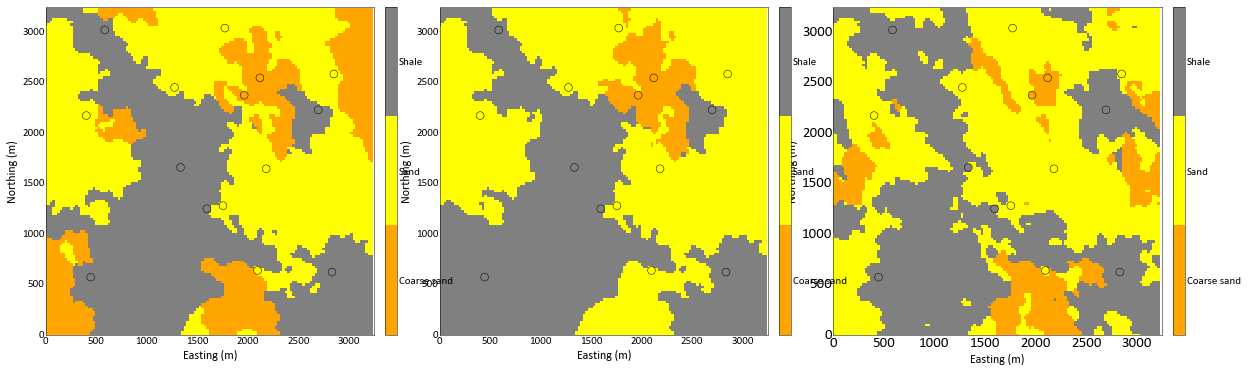

In [58]:
fig, axs = plt.subplots(1,3, figsize=(20,20))

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for n, i in enumerate(SIS_methods):
    
    gs.location_plot(sampled_data, var = 'RT', s = 60, title='Samples', ax=axs[n], edgecolor = 'black',
                         linewidth=0.5, cmap=cmap_fac, xlim=(0,3250), ylim=(0,3250))
    
    gs.slice_plot(get_realization(Facies_sim[n].data,1), catdata= True, catdict=input_data.catdict
              , griddef = griddef, orient = 'xy', ax=axs[n], title = '', clim=(1,3), cmap=cmap_fac)
    
gs.export_image(figdir + 'Facies_model_dif_methods.png', dpi = 150)    

# Model analisys

In [59]:
# Load the nscore program program and its parameter file
postsim = gs.Program(program = exedir + "postsim", getpar=True)

F:\py\Geostatistics principles\Facies_modeling\tmpkt0re_tz\postsim.par has been copied to the clipboard


In [60]:
parstr = """                  Parameters for POSTSIM
                  **********************

START OF PARAMETERS:
{data}                           -file with realizations
{nreal}      1                   -   number of realizations, optional column number
-0.001   1.0e21                  -   trimming limits
{nx}   {ny}   1                  -nx, ny, nz
{output}                         -file for output array(s)
7   0.25                         -output option, output parameter
3  1  2  3                       -if 7,  number of categories, categories
kt3d.out                         -if 10, kriged model to correct to


option 1 = E-type mean and conditional variance
       2 = prob and mean above threshold (par)
       3 = Z-percentile corresponding to (par)
       4 = symmetric (par) probability interval
       6 = prob to be within (par) % of the mean
       7 = summarize categorical variable realizations
      10 = correct to kriged model
"""

SIS_methods = ['SK','OK','LVM']

for i in SIS_methods:
    postsim.run (parstr.format (data = outdir + 'BlockSIS_{}.out'.format(i), nreal = nreal, nx = griddef.nx,
                                ny = griddef.ny, output = outdir + 'postsim_{}.out'.format(i)
                               ))

Calling:  ['./exes/postsim', 'temp']

 POSTSIM Version: 3.800

  data file with realizations = ./facies_model_sis//outputs/BlockSIS_SK.
  lower trimming limit =  -1.0000000E-03
  grid size (nx,ny,nz) =          130         130           1
  output file = ./facies_model_sis//outputs/postsim_SK.o
  output option and parameter:           7  0.2500000    
  number of categories:  3
            categories:    1   2   3
 
    working on loop    1 of    1

 POSTSIM Version: 3.800 Finished

Calling:  ['./exes/postsim', 'temp']

 POSTSIM Version: 3.800

  data file with realizations = ./facies_model_sis//outputs/BlockSIS_OK.
  lower trimming limit =  -1.0000000E-03
  grid size (nx,ny,nz) =          130         130           1
  output file = ./facies_model_sis//outputs/postsim_OK.o
  output option and parameter:           7  0.2500000    
  number of categories:  3
            categories:    1   2   3
 
    working on loop    1 of    1

 POSTSIM Version: 3.800 Finished

Calling:  ['./exes/posts

In [61]:
postsim_results = []

for i in SIS_methods:
    temp = gs.DataFile(outdir + 'postsim_{}.out'.format(i))
    postsim_results.append(temp)

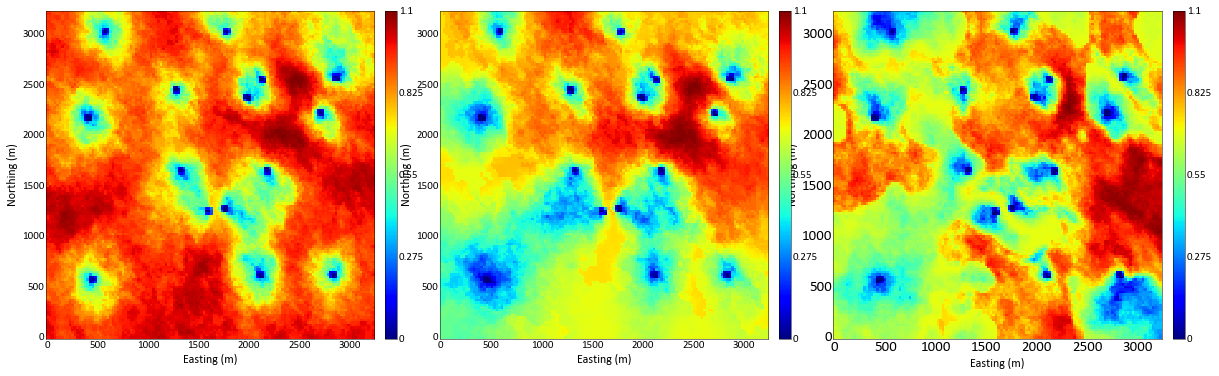

In [62]:
fig, axs = plt.subplots(1,3, figsize=(20,20))

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for n, i in enumerate(SIS_methods):
     gs.slice_plot(postsim_results[n], var = 'Entropy [ -sum(pk x ln(pk)) ]', griddef = griddef, 
                   orient = 'xy', ax=axs[n], title = '', clim=(0,1.1), cmap='jet')